This notebook takes the extracted depth slice of the kernel and plots it,
as in the paper.

The code in this notebook is made available under the [GPLv2 license](../LICENSE.md).

In [1]:
import itertools
import os
from collections import defaultdict, namedtuple

import numpy as np

# Plotting
%matplotlib nbagg
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

# For azimuth and distance calculations.
from geographiclib.geodesic import Geodesic

# To read the CMTSOLUTION file.
from obspy import read_events

In [2]:
# Some values from constants.h
R_EARTH = 6371000
R_EARTH_KM = R_EARTH / 1000
FLATTENING_F = 1.0 / 299.8e0

In [3]:
# GJI class says text width is 42 picas, minus 2pc between columns.
FIG_WIDTH = 20 * 12 / 72.27
# Three rows of Mercator with three title lines + y label, though
# this value is pretty trial-and-error.
FIG_HEIGHT = 3 * (FIG_WIDTH * 75 / 360) + 4 * 14 / 72.27
# Limit for colour bar.
LIM = 2e-6
CMAP_SCALE = 6

In [4]:
DEPTHS = [35, 125]
FILTERS = ['40-60s', '40-120s']
WAVE_TYPES = [('', 'bulk_betav'), ('_l', 'bulk_betah')]

In [5]:
# Directories and full/short names for labelling.
UNDO_TYPES = ['fa', 'pd']
UNDO_NAMES = ['Exact Attenuation (Process C)',
              'Physical Dispersion Only (Process B)']

In [6]:
# From Colorbrewer Set1.
RED = '#e41a1c'
GREEN = '#4daf4a'
BLUE = '#377eb8'

In [7]:
# The STIX font blends well with Times (as used in GJI).
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = ['STIXGeneral']

In [8]:
# NOTE: The mesh should be the same no matter which method is used.
BASEDIR = 'DATA'

In [9]:
cmt = os.path.join(BASEDIR, 'CMTSOLUTION_Love')
sta = os.path.join(BASEDIR, 'STATIONS')
parfile = os.path.join(BASEDIR, 'Par_file_FA')

# Load kernel data

In [10]:
SurfaceData = namedtuple('SurfaceData', 'latitude longitude kernel')

kernel = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for slice_depth in DEPTHS:
    for wave_type, matprop in WAVE_TYPES:
        for filt in FILTERS:
            for undo_type in UNDO_TYPES:
                filename = os.path.join('s40rts_%s%s_T%s' % (undo_type, wave_type, filt),
                                        'reg_1_depth%d_%s_kernel.npz' % (slice_depth, matprop))

                with np.load(filename) as file_data:
                    data = SurfaceData(latitude=file_data['latitude'],
                                       longitude=file_data['longitude'],
                                       kernel=np.ma.MaskedArray(file_data['kernel'],
                                                                file_data['kernel_mask']))

                kernel[slice_depth][wave_type][filt][undo_type] = data

# Determine point in middle of ray path

## Find event location

In [11]:
# Obtain event location
origin = read_events(cmt, format='CMTSOLUTION')[0].preferred_origin()
event_lat = origin.latitude
event_lon = origin.longitude

## Find station location

In [12]:
# Obtain station location
data = np.genfromtxt(sta)
if data.ndim != 1:
    raise ValueError('ERROR: STATIONS files "%s" should contain only one '
                     'station!' % (sta, ))
station_lat = data[2]
station_lon = data[3]

## Find midpoint

In [13]:
geod = Geodesic.WGS84.Inverse(event_lat, event_lon,
                              station_lat, station_lon)
central_point = Geodesic.WGS84.Direct(geod['lat1'], geod['lon1'], geod['azi1'],
                                      geod['s12'] / 2)
central_point

{'a12': 30.100922694629293,
 'azi1': 90.0,
 'azi2': 90.0,
 'lat1': 0.0,
 'lat2': 0.0,
 'lon1': 0.0,
 'lon2': 29.999999999999996,
 's12': 3339584.723798207}

# Plot data on Mercator projection

In [14]:
def plot_full_arc(bbox, data, name, show_bottom=False):
    """
    Plot data on a Mercator projection.

    The axes are created at bbox, with a Mercator projection centred
    opposite the source.
    """
    globe = ccrs.Globe(semimajor_axis=R_EARTH, flattening=FLATTENING_F)
    proj = ccrs.Mercator(central_longitude=event_lon + 180, globe=globe)
    ax = fig.add_axes(bbox, projection=proj)
    ax.set_extent([event_lon - 10, event_lon + 370, -40, 40])

    mesh = ax.pcolormesh(data.longitude, data.latitude, data.kernel,
                         cmap='RdBu', vmin=-LIM, vmax=LIM, edgecolor='none',
                         transform=ccrs.PlateCarree(), rasterized=True)

    # Station/event markers.
    ax.scatter(event_lon, event_lat,
               c=RED, s=50, marker='*', transform=ccrs.Geodetic(), zorder=10)
    ax.scatter(event_lon + 360, event_lat,
               c=RED, s=50, marker='*', transform=ccrs.Geodetic(), zorder=10)
    ax.scatter(station_lon, station_lat,
               c=GREEN, s=50, marker='v', transform=ccrs.Geodetic(), zorder=10)
    # Antipode markers.
    ax.scatter(event_lon + 180, event_lat,
               c='w', s=50, marker='*', transform=ccrs.Geodetic(), zorder=10)
    ax.scatter(station_lon + 180, station_lat,
               c='w', s=50, marker='v', transform=ccrs.Geodetic(), zorder=10)

    ax.coastlines(resolution='110m')
    gl = ax.gridlines(xlocs=np.arange(0, 361, 30),
                      ylocs=np.arange(-40, 41, 20))
    gl.xlabels_bottom = show_bottom
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 6}
    gl.ylabels_left = True
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'fontsize': 6}

    # We don't have the entire global surface, so fill the background with 
    # the middle colour (== 0.0 once the colour range is set.)
    ax.background_patch.set_color(plt.cm.RdBu(0.5))

    ax.set_title(r'$\mathbf{(%s)}$ %s' % (next(subfigs), name),
                 fontsize=8)

    return mesh

In [15]:
plt.close('all')
redraw = True

In [16]:
def plot_set(kernel_data):
    pd_data = kernel_data['pd']
    fa_data = kernel_data['fa']

    # First two rows contain results.
    bbox = [0.06, 1.0 - 0.33, 0.85, 0.3]
    meshes['fa'] = plot_full_arc(bbox, fa_data, 'Exact Attenuation (Process C)')
    bbox = [0.06, 1.0 - 2 * 0.33, 0.85, 0.3]
    meshes['pd'] = plot_full_arc(bbox, pd_data, 'Physical Dispersion Only (Process B)')

    # Last row shows difference with exact result.
    diff_data = SurfaceData(fa_data.latitude, fa_data.longitude,
                            (pd_data.kernel - fa_data.kernel))
    bbox = [0.06, 1.0 - 3 * 0.33, 0.85, 0.3]
    meshes['diff'] = plot_full_arc(bbox, diff_data, 'Difference between Processes B and C',
                                   show_bottom=True)

    # Show a colour bar, with some fixed limits, right of the results.
    cax = fig.add_axes([0.92, 0.04, 0.01, 0.90])
    cax.set_title(r'$K_{\alpha}$ ($10^{-%d}$ s$^2$/km$^3$)  ' % (CMAP_SCALE, ),
                  fontsize=6)
    cax.tick_params(direction='out', labelsize=6, pad=0)
    cb = fig.colorbar(meshes['fa'], cax=cax, orientation='vertical',
                      ticks=np.arange(-1, 1.1, 0.25) * LIM,
                      format=mticker.FuncFormatter(lambda x, pos: '%.1f' % (x * 10**CMAP_SCALE, )))
    cb.solids.set_rasterized(True)

    return meshes

<IPython.core.display.Javascript object>


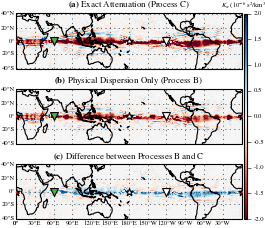

In [17]:
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
meshes = {}
subfigs = iter(chr(ord('a') + i % 26) for i in itertools.count())

In [18]:
plot_set(kernel[35]['_l']['40-60s'])
if redraw:
    fig.canvas.draw()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


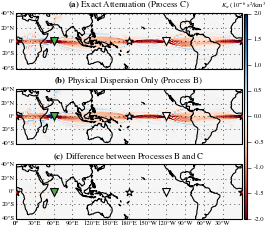

<IPython.core.display.Javascript object>


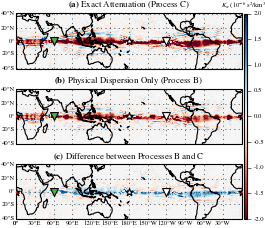

<IPython.core.display.Javascript object>


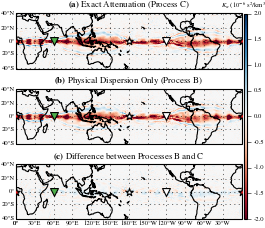

<IPython.core.display.Javascript object>


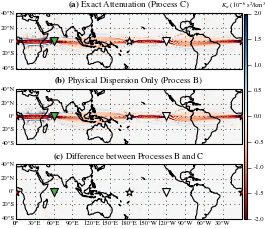

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


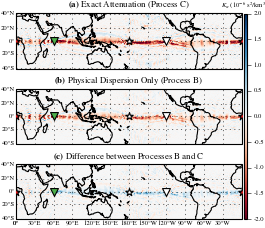

<IPython.core.display.Javascript object>


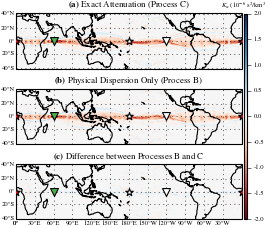

In [19]:
for slice_depth in DEPTHS:
    for wave_type, matprop in WAVE_TYPES:
        for filt in FILTERS:
            filename = 's40rts_%s_depth%d_filt%s_%s.pdf' % (
                'Rayleigh' if wave_type == '' else 'Love',
                slice_depth,
                filt,
                matprop
            )

            fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
            meshes = {}
            subfigs = iter(chr(ord('a') + i % 26) for i in itertools.count())
            plot_set(kernel[slice_depth][wave_type][filt])
            fig.savefig(filename, dpi=300)

# License Statement
Copyright (C) 2016  Elliott Sales de Andrade

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.